# Deep Learning: CNN: Cancer Detection
**Thomas Bohn**   --   **2025-09-14**

{{xxxxx}}  

--  [Main Report](xxxx)  --  [Github Repo](xxxx)  --  [Presentation Slides](xxx)  --  [Presentation Video](xxx) --  

# 1.&nbsp;Introduction

**Problem Statement**

{{xxxxx}}

**Why is it Important?**

{{xxxxx}}

**Limitations of Existing Solutions**

{{xxxxx}}

**Contribution**

{{xxxxx}}

**DataSet**

{{xxxxx}}


## Python Libraries

The following python libraries are used in this notebook.

In [38]:
# File system manangement
import time, datetime, psutil, os
import shutil
import zipfile
from google.colab import userdata
from google.colab import files

# Data manipulation
import numpy as np
import pandas as pd
import math

# Install text storage and manipulation
import re
import json
import pickle
import textwrap

#Install Image processing
from PIL import Image

##################################

# Plotting and visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
import seaborn as sns
sns.set_theme()

# Train-test split and cross validation
from sklearn.model_selection import train_test_split, ParameterGrid

# Model Evaluation
from sklearn import metrics
from sklearn.metrics import accuracy_score

#################################

# Import Tensor Flow and Keras
import tensorflow as tf
import keras
from keras import layers, models
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

## Global Variables

The following are global variables referenced in this notebook.

In [4]:
# Recording the starting time, complemented with a stopping time check in the end to compute process runtime
start = time.time()

# Class representing the OS process and having memory_info() method to compute process memory usage
process = psutil.Process(os.getpid())

In [5]:
# Global Debug flag used to turn on and off more chatty blocks of code
gDEBUG = True
if gDEBUG: print('Debug is set to:', gDEBUG)
# Global Level of Detail of table stats and details
gLOD = 2
print('Level of Detail for functions is set to:', gLOD)

Debug is set to: True
Level of Detail for functions is set to: 2


# 2.&nbsp;Data Source

In this section, the code loads the dataset from Google Drive.

{{xxxxx}}

## Import the Data

In [6]:
# Mount the Google Drive
from google.colab import drive
drive.mount('/content/drive')

target_file = 'histopathologic-cancer-detection.zip'
source_path_root =  '/content/drive/MyDrive/[1.4] MsDS Class Files/-- DTSA 5511 Deep Learning/data'
destination_path_root = '/content'

shutil.copy(source_path_root+'/'+target_file, destination_path_root+'/')

print(os.listdir(destination_path_root+'/'))

Mounted at /content/drive
['.config', 'histopathologic-cancer-detection.zip', 'drive', 'sample_data']


In [7]:
# Unzip the files
zip_file_path = destination_path_root+'/'+target_file

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Extract all the contents into the specified folder
        zip_ref.extractall(destination_path_root)

In [8]:
file_path_root =  '/content'


file_path_train   = file_path_root + '/train'
file_path_test    = file_path_root + '/test'
file_path_labels  = file_path_root + '/train_labels.csv'
file_path_sample  = file_path_root + '/sample_submission.csv'

# Load train labels from CSV file
train_labels = pd.read_csv(file_path_labels)

# Load test labels from CSV file
sample_output = pd.read_csv(file_path_sample)

In [9]:
if gDEBUG:
  # Preview the Data Sources
  print("Sample of Training Labels")
  display(train_labels.head(5))
  print()
  print("Sample of Results Output:")
  display(sample_output.head(5))

Sample of Training Labels


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0



Sample of Results Output:


,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [10]:
print("Training Labels Info:")
print(train_labels.info())

Training Labels Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None


In [11]:
# Get training and testing files
train_file_names = os.listdir(file_path_train)
test_file_names = os.listdir(file_path_test)

print('Total Training Files: ', len(train_file_names))
print('Total Testing Files: ', len(test_file_names))
pct_assigned_train = round(len(train_file_names) / (len(train_file_names) + len(test_file_names)), 3)
print('Percent Assigned to Training: ', pct_assigned_train)
print()

print('Preview of training image file names: ')
print(train_file_names[:10])
print('Preview of testing image file names: ')
print(test_file_names[:10])

Total Training Files:  220025
Total Testing Files:  57458
Percent Assigned to Training:  0.793

Preview of training image file names: 
['c823338229d6b73b00b7b4e55e7b699a3401ee3f.tif', '8d82f3bd017724fb7647df92fd501328d382a707.tif', 'dd3213361e77be50c160617223ca076111d3569f.tif', 'bef0b669b473bc2aff91467822f31167acaaf609.tif', '8dc08b595911a645f67bc3a5d6048cca2ed09985.tif', 'b9617df1085ba874cbbed39345d2c7ff09bcee5b.tif', '1ec5d65d222384d8e1fde325080a37dcb3bdf8f2.tif', '81b6880e7c30834bb6921fa925f7b5424c6a85da.tif', 'bef553a4d5fb9b60c3f938bfde475e9b194c7351.tif', 'bcc86858083649cf21f87e8a81af73585246be4f.tif']
Preview of testing image file names: 
['77c8a993a6554adb01847c6dad00debbdac42e6c.tif', '55244dff457bea22745ae67b3c4a87ac3c260ac6.tif', '50d0c5068db837b20292564c903ed1f902246d61.tif', 'e607d2e3693253a1ac55324de79ebe1f685451eb.tif', '2b29fe81d4545bc0a443c679a17eeeb8dcbe0483.tif', 'af438608ba4cb92d35cae44ed710f143563977cb.tif', '9941dc54d4568b5c1cd1c9054d6c3463371eb782.tif', 'a6ef9669

In [12]:
 # Preview the Data Sources
print('Label Count of Training Labels')
display(train_labels['label'].value_counts())
print()
print('Imbalance of Labels:', round((train_labels['label'].value_counts()[1]
                                    - train_labels['label'].value_counts()[0]) / len(train_labels), 3))

Label Count of Training Labels


,count
label,
0,130908
1,89117



Imbalance of Labels: -0.19


## Data Preparation

In [13]:
#{{xxxxx}}

## Address Missing Values

In [14]:
#{{xxxxx}}

## Data Scoping Functions

In [15]:
#{{xxxxx}}

## Scope the Label and Text for Analysis

In [16]:
#{{xxxxx}}

# 3.&nbsp;Exploratory Data Analysis (EDA)

The EDA phase focuses on understanding the dataset, including data distribution and label counts. Various functions are used to inspect the structure of the dataset, visualize the label distribution, and assess the text length and word count of the documentation. The data is found to be somewhat imbalanced across categories.

## EDA Functions

In [17]:
def preview_images(df, file_path_train, target_label, num_previews=2):
    previews = df[df['label'] == target_label].sample(num_previews)
    plt.figure(figsize=(15, 3))
    for idx, img_name in enumerate(previews['id']):
        img_path = file_path_train + '/' + img_name + '.tif'
        print(img_path)
        img = Image.open(img_path)
        plt.subplot(1, num_previews, idx+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(f'Preview of Images for Label {target_label}')
    plt.show()

## EDA Analysis: Overview

/content/train/8c59189f4e7c82c3a25017cce02c5521ee86262d.tif
/content/train/0d51bdc85b9067dafbd1bb64691fa2b1544589f8.tif
/content/train/1ccabe491f4c5f7c3729597d579e0bd6a1c7bc34.tif
/content/train/53e0f9c4282907afc2419292f8733c72222de227.tif


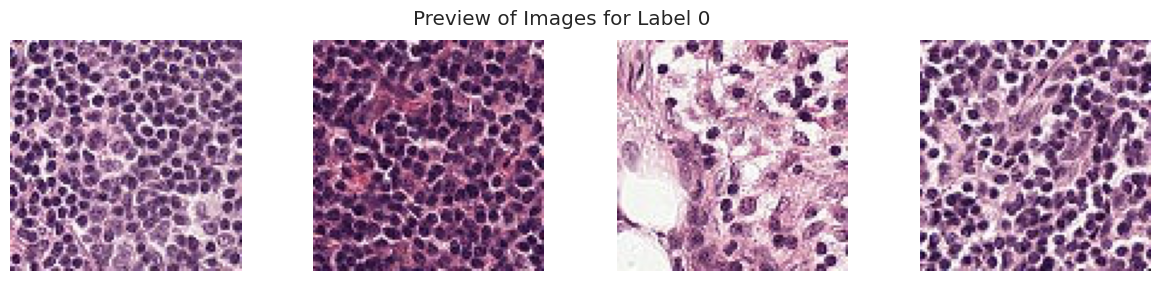

/content/train/9c7989aa2cf99cd70bbe4a3f9d144693b09852ea.tif
/content/train/ec7af31034d77407eaad272b12a91c84f99a82c3.tif
/content/train/ea70e03beb0861effdd9b665711936609a68c7a6.tif
/content/train/b348c96e20d76ed56aacb5a819bd0e68de23ac66.tif


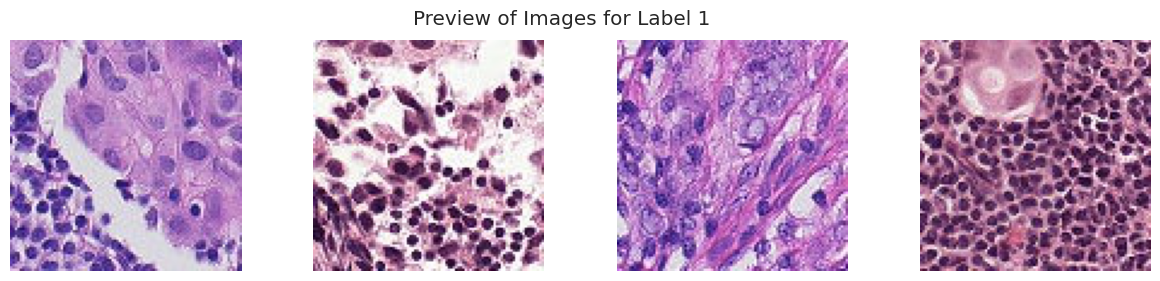

In [18]:
preview_images(df=train_labels, file_path_train=file_path_train, target_label=0, num_previews=4)
preview_images(df=train_labels, file_path_train=file_path_train, target_label=1, num_previews=4)

## EDA Analysis: Class Distribution

Size of the training set: 220025

Labels in training set: 2

Columns in test set: Index(['id', 'label'], dtype='object')



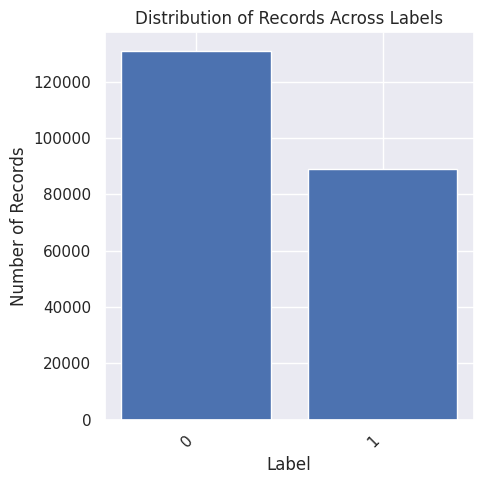

In [19]:
  print("Size of the training set:", len(train_labels))
  print()
  print("Labels in training set:", train_labels['label'].nunique())
  print()
  print("Columns in test set:", train_labels.columns)
  print()

  # Create a histogram for the count of records in each label
  label_counts = train_labels['label'].value_counts()
  plt.figure(figsize=(5, 5))
  plt.bar(label_counts.index.astype(str), label_counts.values)
  plt.xlabel('Label')
  plt.ylabel('Number of Records')
  plt.title('Distribution of Records Across Labels')
  plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
  plt.tight_layout()
  plt.show()

## EDA Results

ADD HERE

# 4.&nbsp;Train-Validation-Test Split

Split the dataset into training, validation, and test sets. Use tratified splitting to ensure that the class distribution remains consistent across these sets. The distribution of records across the labels is visualized to ensure a balanced split.

# Reduce Record Volume

In [20]:
#Downsample the amount of records for testing (and balance classes)
sample_size = 1000

train_0 = train_labels[train_labels['label'] == 0].sample(sample_size, random_state = 27)
train_1 = train_labels[train_labels['label'] == 1].sample(sample_size, random_state = 27)

train_labels_balanced = pd.concat([train_0, train_1], axis=0).reset_index(drop=True)

## Test Split Functions

In [21]:
train_df, valid_df = train_test_split(train_labels_balanced, test_size=0.2, stratify=train_labels_balanced['label'], random_state=27)

In [22]:
train_df['label'] = train_df['label'].astype(str)
train_df['file_name'] = train_df['id'] + '.tif'

train_df.head(5)

,id,label,file_name
776,f4b2912f15511c7a9493661987ec33f97789bdb5,0,f4b2912f15511c7a9493661987ec33f97789bdb5.tif
577,a0df8aaedece8633049bdf5447d46939c5916327,0,a0df8aaedece8633049bdf5447d46939c5916327.tif
206,4676318b836d0b8abc65295e678050531df28bbe,0,4676318b836d0b8abc65295e678050531df28bbe.tif
864,a2c274926614081b22ed1dc65340f2688e48cd0c,0,a2c274926614081b22ed1dc65340f2688e48cd0c.tif
1419,68b97cab3f89d9f1ce7547792ad2ee7caac4c545,1,68b97cab3f89d9f1ce7547792ad2ee7caac4c545.tif


In [23]:
valid_df['label'] = valid_df['label'].astype(str)
valid_df['file_name'] = valid_df['id'] + '.tif'

valid_df.head(5)

,id,label,file_name
1115,a1bd178734975cb074ed8bdae7088d77aacd9bca,1,a1bd178734975cb074ed8bdae7088d77aacd9bca.tif
1870,2727414cb9e4561de7b5f4d56f4901c98f51c851,1,2727414cb9e4561de7b5f4d56f4901c98f51c851.tif
688,4fcd244b0478b53af5bc9a0a5225b0f846a5a977,0,4fcd244b0478b53af5bc9a0a5225b0f846a5a977.tif
192,320b6c62f8741d10f118be308f1b2f6ca1ec9703,0,320b6c62f8741d10f118be308f1b2f6ca1ec9703.tif
167,97ad518b77e5a19753cee93ec2acbc128b54b47d,0,97ad518b77e5a19753cee93ec2acbc128b54b47d.tif


## Test Split Analysis

In [26]:
 # Preview the Data Sources
print('Label Count of Training Labels')

display(train_df['label'].value_counts())
print()
print('Imbalance of Labels:', round((train_df['label'].value_counts()['1']
                                    - train_df['label'].value_counts()['0']) / len(train_df), 3))
print()
print('Label Count of Validation Labels')
display(valid_df['label'].value_counts())
print()
print('Imbalance of Labels:', round((valid_df['label'].value_counts()['1']
                                    - valid_df['label'].value_counts()['0']) / len(valid_df), 3))

Label Count of Training Labels


,count
label,
0,800
1,800



Imbalance of Labels: 0.0

Label Count of Validation Labels


,count
label,
1,200
0,200



Imbalance of Labels: 0.0


# 5.&nbsp;Data Cleansing & Text Normalization

{{xxxxx}}

## Core Normalization Functions

In [27]:
#{{xxxxx}}

## Apply Text Normalization

In [28]:
#{{xxxxx}}

# 6.&nbsp;Image Preprocessing

[tf.keras.preprocessing.image.ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

In [29]:
#shared variables for image pre-processing
target_size = (96, 96)
batch_size=64

## Training Data Generator

In [45]:
train_img_gen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True
)

train_generator = train_img_gen.flow_from_dataframe(
    dataframe=train_df,
    directory=file_path_train,
    x_col='file_name',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary'
)

Found 1600 validated image filenames belonging to 2 classes.


## Validation Data Generator

In [46]:
valid_img_gen = ImageDataGenerator(
    rescale=1./255
)

validation_generator = valid_img_gen.flow_from_dataframe(
    dataframe=valid_df,
    directory=file_path_train,
    x_col='file_name',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary'
)

Found 400 validated image filenames belonging to 2 classes.


## Testing Data Generator

In [47]:
test_df = pd.DataFrame({'id': os.listdir(file_path_test)})

test_img_gen = ImageDataGenerator(
    rescale=1./255
)

test_generator = test_img_gen.flow_from_dataframe(
    dataframe=test_df,
    directory=file_path_test,
    x_col='id',
    y_col=None,
    target_size=target_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode=None
)

Found 57458 validated image filenames.


# 7.&nbsp; Baseline Model

## Model Functions

In [51]:
def learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 10))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')

## Build the Model Architecture

In [54]:
config_model_0 = [
    # Define the input shape
    Input(shape=(96, 96, 3)),
    #Layer 1
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    #Layer 2
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # ANN
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
]

In [55]:
model_0 = Sequential(config_model_0)

In [56]:
learning_rate_model_0 = 0.001
optimizer_model_0 = keras.optimizers.Adam(learning_rate = learning_rate_model_0)

In [57]:
model_0.compile(
    optimizer = optimizer_model_0,
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [58]:
model_0.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,984,577 (15.20 MB)

 Trainable params: 3,984,577 (15.20 MB)

 Non-trainable params: 0 (0.00 B)

### Train/Fit the Model

In [50]:
history_0 = model_0.fit(
    train_generator,
    validation_data=validation_generator,
    epochs = 10
)
history_0

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.4988 - loss: 0.9132 - val_accuracy: 0.6700 - val_loss: 0.5958
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.6697 - loss: 0.6147 - val_accuracy: 0.7925 - val_loss: 0.5013
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.6985 - loss: 0.6075 - val_accuracy: 0.8025 - val_loss: 0.4775
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7367 - loss: 0.5491 - val_accuracy: 0.7400 - val_loss: 0.5432
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7254 - loss: 0.5717 - val_accuracy: 0.8000 - val_loss: 0.4782
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.7719 - loss: 0.5071 - val_accuracy: 0.8250 - val_loss: 0.4511
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7891 - loss: 0.4606 - val_accuracy: 0.8050 - val_loss: 0.4584
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7677 - loss: 0.4920 - val_accuracy: 0.8025 - val_loss:

### Evaluate the Model

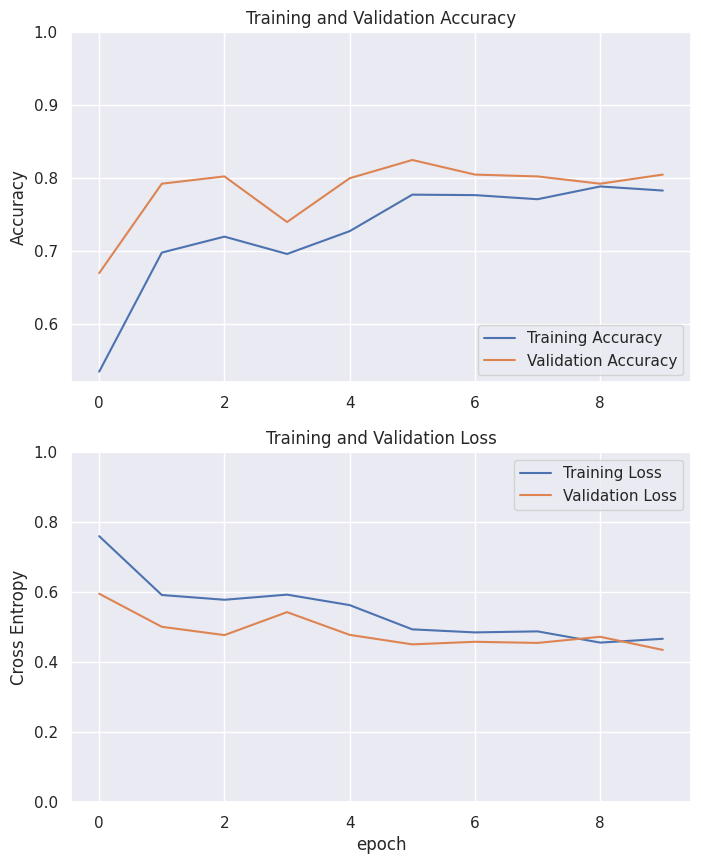

In [53]:
learning_curve(history_0)

# 8.&nbsp; Hyperparameter Tuning

## Improvement 1: Adding More Layers

In [ ]:
config_model_1 = [
    # Define the input shape
    Input(shape=(96, 96, 3)),
    #Layer 1
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    #Layer 2
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # ANN
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
]

model_1 = Sequential(config_model_1)

learning_rate_model_1 = 0.001
optimizer_model_1 = keras.optimizers.Adam(learning_rate = learning_rate_model_1)

model_1.compile(
    optimizer = optimizer_model_1,
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

model_1.summary()

In [ ]:
history_1 = model_1.fit(
    train_generator,
    validation_data=validation_generator,
    epochs = 10
)
history_1

In [ ]:
learning_curve(history_1)

## Improvement 2: Batch Normalization and Dropout

In [ ]:
config_model_2 = [
    # Define the input shape
    Input(shape=(96, 96, 3)),
    #Layer 1
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    #Layer 2
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # ANN
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
]

model_2 = Sequential(config_model_2)

learning_rate_model_2 = 0.001
optimizer_model_2 = keras.optimizers.Adam(learning_rate = learning_rate_model_2)

model_2.compile(
    optimizer = optimizer_model_2,
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

model_2.summary()

In [ ]:
history_2 = model_2.fit(
    train_generator,
    validation_data=validation_generator,
    epochs = 10
)
history_2

In [ ]:
learning_curve(history_2)

## Improvement 3: Slower Learning, More Epics, Early Stopping

In [ ]:
config_model_3 = [
    # Define the input shape
    Input(shape=(96, 96, 3)),
    #Layer 1
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    #Layer 2
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # ANN
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
]

model_3 = Sequential(config_model_2)

learning_rate_model_3 = 0.001
optimizer_model_3 = keras.optimizers.Adam(learning_rate = learning_rate_model_3)

model_3.compile(
    optimizer = optimizer_model_3,
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

model_3.summary()

In [ ]:
history_3 = model_3.fit(
    train_generator,
    validation_data=validation_generator,
    epochs = 10
)
history_3

In [ ]:
learning_curve(history_3)

# 9.&nbsp;Final Prediction and Evaluation

## Evaluation Functions

In [ ]:
{{xxxxx}}

## Train the Final Model

In [ ]:
{{xxxxx}}

## Evaluate the Model

In [ ]:
{{xxxxx}}

## Explore Errors

In [ ]:
{{xxxxx}}

# 10.&nbsp;Scale the Auto-Classifier

## Auto-Classifier Functions

In [ ]:
{{xxxxx}}

## Rerun Process for L1

In [ ]:
{{xxxxx}}

## Rerun Process for L2

In [ ]:
{{xxxxx}}

# 11.&nbsp; Conclusions

{{xxxxx}}

## Results Summary

### Model Result Summary


**Baseline Results**

{{xxxxx}}

**Hyperparameter Tuning Results**

{{xxxxx}}

**Best Model Results**

{{xxxxx}}

**Best Model Performance**

{{xxxxx}}

## Model Comparison

### Model Comparisons and Findings

{{xxxxx}}

#### Baseline Results

{{xxxxx}}

#### Hyperparameter Tuning

{{xxxxx}}

#### Best Model Results

{{xxxxx}}

#### Performance Breakdown (Best Model)

{{xxxxx}}

#### Conclusion

{{xxxxx}}

## Concluding Observations

## Patterns and Conclusions Across the Models

{{xxxxx}}

# 12.&nbsp; References

**Kaggle Competition**

- [1] Will Cukierski. Kaggle. 2018. Histopathologic Cancer Detection. https://www.kaggle.com/c/histopathologic-cancer-detection/overview

**Kaggle File Import to Colab**
- [2] Abdul Qadir. 2020. Data Preparation Guide for detecting Histopathologic Cancer Detection https://towardsdatascience.com/data-preparation-guide-for-detecting-histopathologic-cancer-detection-7b96d6a12004/
- [3] Abdul Qadir. 2020. Histopathlogic-Cancer-Data-Preprocessing. https://github.com/DarthQadir/Histopathlogic-Cancer-Data-Preprocessing/tree/master

**References Resources**
- [4] Faramarz Kowsari. CNN_Histopathologic_Cancer_Detection_Colorado. 2023. https://www.kaggle.com/code/faramarzkowsari/cnn-histopathologic-cancer-detection-colorado
- [5] Kodai Fukuda. Histopathologic Cancer Detection with CNN. 2024. https://www.kaggle.com/code/kodaifukuda0311/histopathologic-cancer-detection-with-cnn